In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report,roc_curve, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import logging
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from tqdm import tqdm

#Import necessary libraries, it was small as it started but then it gradually increased with more changes.

In [5]:
df = pd.read_csv('Loan_Default.csv')
df['Status']
#Read the datasset and display it for now.  

0         1
1         1
2         0
3         0
4         0
         ..
148665    0
148666    0
148667    0
148668    0
148669    0
Name: Status, Length: 148670, dtype: int64

In [3]:
df['loan_amount']

0         116500
1         206500
2         406500
3         456500
4         696500
           ...  
148665    436500
148666    586500
148667    446500
148668    196500
148669    406500
Name: loan_amount, Length: 148670, dtype: int64

## Create varying subplots to visualize data distribution and correlations

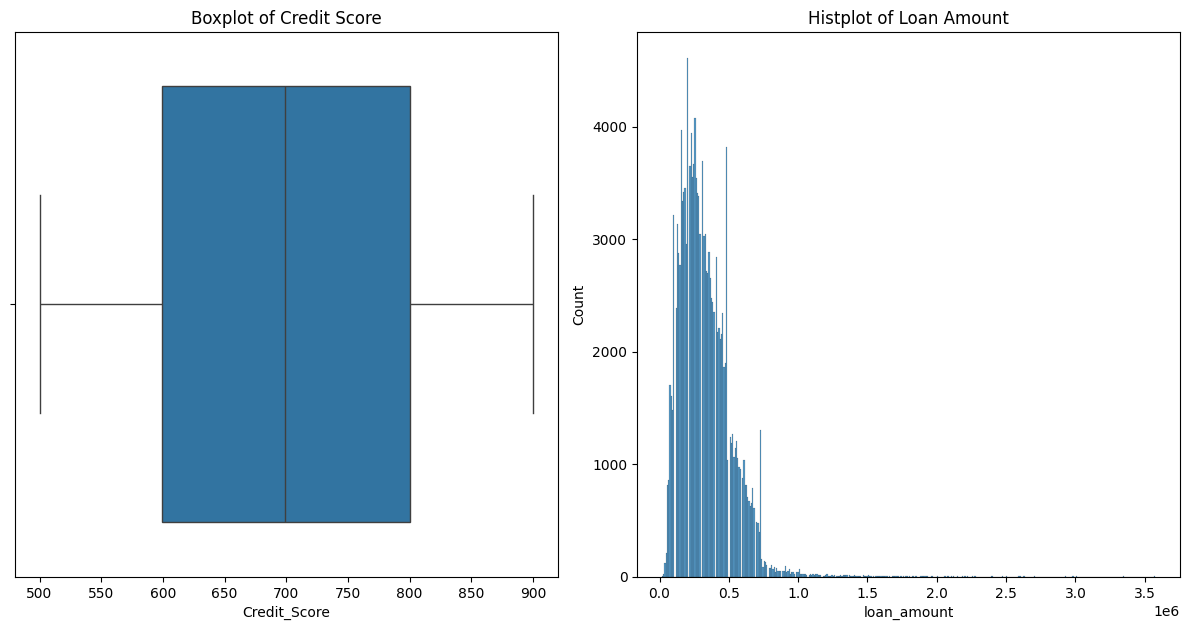

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 rows and 2 columns
plt.figure(figsize=(12, 12))

# Subplot of credit score
plt.subplot(2, 2, 1)
sns.boxplot(x=df['Credit_Score'])
plt.title('Boxplot of Credit Score')

# Subplot of loan amount
plt.subplot(2, 2, 2)
sns.histplot(x=df['loan_amount'])
plt.title('Histplot of Loan Amount')


# Display the plots
plt.tight_layout()
plt.show()


# Define a function to clean and preprocess the feature names

In [77]:
#Define a function to clean and preprocess the feature names
import re
#Cleans the feature names 
def clean_feature_name(name):
    cleaned_name = re.sub(r'[^\w]', '_', str(name))
    if cleaned_name[0].isdigit():
        cleaned_name = 'f_' + cleaned_name
    return cleaned_name

#Used to preprocess the data
def preprocess_data(df):
    df = df.copy()
    
    logging.info("Starting data preprocessing")

    # Separate target variable
    target = df['Status']
    
    # Drop the target variable and any other unwanted features
    features = df.drop(['Status', 'Interest_rate_spread','Upfront_charges'], axis=1)
    #Include some helpful logging
    logging.info(f"Shape of features after dropping target and unwanted columns: {features.shape}")

    # Identify numeric and categorical columns
    numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = features.select_dtypes(include=['object']).columns

    logging.info(f"Numeric features: {numeric_features.tolist()}")
    logging.info(f"Categorical features: {categorical_features.tolist()}")

    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Fit the preprocessor and transform the features
    features_preprocessed = preprocessor.fit_transform(features)
    
    # Get feature names after preprocessing
    onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(numeric_features) + list(onehot_columns)
    
    # Clean feature names
    cleaned_feature_names = [clean_feature_name(name) for name in feature_names]

    logging.info(f"Number of features after preprocessing: {len(cleaned_feature_names)}")
    logging.info("Data preprocessing completed")

    return features_preprocessed, target, preprocessor, cleaned_feature_names, numeric_features, categorical_features

## Create the features array we're going to use for later processing

In [ ]:

features_preprocessed, target, preprocessor, feature_names, numeric_features, categorical_features = preprocess_data(df)

# Convert to DataFrame
print(feature_names)
X = pd.DataFrame(features_preprocessed, columns=feature_names)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
# SMOTE isn't practical for real world datasets, but it's a good starting point for this demonstration.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Create the full pipeline including SMOTE and XGBoost
xgb_pipeline = Pipeline([
    ('classifier', XGBClassifier(random_state=42))
])




# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__min_child_weight': [1, 3],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.8, 0.9]
}


# Perform cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
# cv_scores = cross_val_score(xgb_pipeline, X, target, cv=cv, scoring='roc_auc')
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the XGBoost model
grid_search.fit(X_train_resampled, y_train_resampled)


# Get feature importances from the best model
best_model = grid_search.best_estimator_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.named_steps['classifier'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)



['ID', 'year', 'loan_amount', 'rate_of_interest', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1', 'loan_limit_cf', 'loan_limit_missing', 'loan_limit_ncf', 'Gender_Female', 'Gender_Joint', 'Gender_Male', 'Gender_Sex_Not_Available', 'approv_in_adv_missing', 'approv_in_adv_nopre', 'approv_in_adv_pre', 'loan_type_type1', 'loan_type_type2', 'loan_type_type3', 'loan_purpose_missing', 'loan_purpose_p1', 'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4', 'Credit_Worthiness_l1', 'Credit_Worthiness_l2', 'open_credit_nopc', 'open_credit_opc', 'business_or_commercial_b_c', 'business_or_commercial_nob_c', 'Neg_ammortization_missing', 'Neg_ammortization_neg_amm', 'Neg_ammortization_not_neg', 'interest_only_int_only', 'interest_only_not_int', 'lump_sum_payment_lpsm', 'lump_sum_payment_not_lpsm', 'construction_type_mh', 'construction_type_sb', 'occupancy_type_ir', 'occupancy_type_pr', 'occupancy_type_sr', 'Secured_by_home', 'Secured_by_land', 'total_units_1U', 'total_units_2U

## Print the top 11 features

In [79]:
# Select top 11 features
top_features = feature_importance.head(11)['feature'].tolist()
print("\nTop 11 features:", top_features)

# Print feature importances
print("\nFeature Importances:")
print(feature_importance.head(20))

# Evaluate on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Additional check: Print confusion matrix
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Top 11 features: ['rate_of_interest', 'credit_type_EQUI', 'Neg_ammortization_neg_amm', 'lump_sum_payment_lpsm', 'submission_of_application_not_inst', 'lump_sum_payment_not_lpsm', 'submission_of_application_to_inst', 'age_missing', 'Neg_ammortization_not_neg', 'approv_in_adv_pre', 'submission_of_application_missing']

Feature Importances:
                               feature  importance
3                     rate_of_interest    0.331541
54                    credit_type_EQUI    0.224162
35           Neg_ammortization_neg_amm    0.032318
39               lump_sum_payment_lpsm    0.026440
67  submission_of_application_not_inst    0.025201
40           lump_sum_payment_not_lpsm    0.023040
68   submission_of_application_to_inst    0.017954
65                         age_missing    0.017879
36           Neg_ammortization_not_neg    0.014445
19                   approv_in_adv_pre    0.014424
66   submission_of_application_missing    0.013381
11                  loan_limit_missing    0.013

### Interpretation of results:
#### True positives: 94848, True Negatives: 29483, False positives: 5936, False negatives: 3536
#### Class-Specific Performance:


#### Class 0 (Non-defaults):

* Precision: 0.96 - When the model predicts a loan won't default, it's right 96% of the time
* Recall: 0.94 - The model correctly identifies 94% of all actual non-defaulting loans
* F1-score: 0.95 - Strong balanced performance for non-defaults
* Support: 100,784 loans (about 75% of the dataset)


#### Class 1 (Defaults):

* Precision: 0.83 - When the model predicts a default, it's right 83% of the time
* Recall: 0.89 - The model correctly identifies 89% of all actual defaults
* F1-score: 0.86 - Good balanced performance for defaults
* Support: 33,019 loans (about 25% of the dataset)




#### Overall Model Performance:


#### Accuracy: 0.93 - The model is correct 93% of the time overall
#### ROC AUC Score: 0.984 - Excellent discriminative ability (very close to perfect 1.0)

### These are decent scores , not realistic given SMOTE but i had to use SMOTE to balance the target class and the model performed well.

In [80]:
#Lets perform some model inference
#Create a function to perform inference, taking in user information and return the probability of default
def predict_pd(user_input, grid_search, preprocessor, feature_names, numeric_features, categorical_features):
    # Create a DataFrame with a single row for the user input
    input_df = pd.DataFrame([user_input])
    
    # Ensure all expected features are present
    for feature in numeric_features.union(categorical_features):
        if feature not in input_df.columns:
            if feature in numeric_features:
                input_df[feature] = df[feature].mean()  # Use mean for numeric features
            else:
                input_df[feature] = df[feature].mode().iloc[0]  # Use mode for categorical features
    
    # Keep only the features used during training
    input_df = input_df[numeric_features.union(categorical_features)]
    
    # Apply preprocessing
    input_preprocessed = preprocessor.transform(input_df)
    
    # Convert to DataFrame with correct feature names
    input_preprocessed_df = pd.DataFrame(input_preprocessed, columns=feature_names)
    
    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Apply feature selection if it's part of the pipeline
    if 'feature_selection' in best_model.named_steps:
        input_selected = best_model.named_steps['feature_selection'].transform(input_preprocessed_df)
    else:
        input_selected = input_preprocessed_df
    
    # Make prediction
    pd_prob = best_model.named_steps['classifier'].predict_proba(input_selected)[0, 1]
    
    return pd_prob * 100  # Convert to percentage

# Function to get feature importance
def get_feature_importance(grid_search, feature_names):
    best_model = grid_search.best_estimator_
    # Extract feature importances from the XGBoost model
    importances = best_model.named_steps['classifier'].feature_importances_
    # Create a dataframe of feature importances
    feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    return feature_imp

# Example usage
user_input = {
    'credit_type': 'EQUI',
    'lump_sum_payment': 'not_lpsm',
    'construction_type': 'sb',
    'Secured_by': 'home',
    'Security_Type': 'Indriect',
    'submission_of_application': 'not_inst',
    'loan_type': 'type3',
    'loan_purpose': 'p1',
    'age': '55-64',
    'Credit_Worthiness': 'l2',
    'income': 500000,
    'Credit_Score': 700,
    'LTV': 70,
    'rate_of_interest' : 4.52
    
}

# Assuming grid_search, preprocessor, feature_names, numeric_features, and categorical_features are available
pd_prob = predict_pd(user_input, grid_search, preprocessor, feature_names, numeric_features, categorical_features)
print(f"Probability of Default: {pd_prob:.2f}%")

# Get and print feature importance
feature_importance = get_feature_importance(grid_search, feature_names)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Probability of Default: 37.82%

Top 10 Most Important Features:
                               feature  importance
3                     rate_of_interest    0.331541
54                    credit_type_EQUI    0.224162
35           Neg_ammortization_neg_amm    0.032318
39               lump_sum_payment_lpsm    0.026440
67  submission_of_application_not_inst    0.025201
40           lump_sum_payment_not_lpsm    0.023040
68   submission_of_application_to_inst    0.017954
65                         age_missing    0.017879
36           Neg_ammortization_not_neg    0.014445
19                   approv_in_adv_pre    0.014424


In [92]:
df['property_value']

0         118000.0
1              NaN
2         508000.0
3         658000.0
4         758000.0
            ...   
148665    608000.0
148666    788000.0
148667    728000.0
148668    278000.0
148669    558000.0
Name: property_value, Length: 148670, dtype: float64

### We can use this to get the probability of default for any user input. The feature importance can be used to understand which features are the most relevant to the model.

### We then need to predict the LGD which is the percentage of exposure that would be lost if default occurs

#### WE have to create proxy LGD data since we don't have actual loss data. In practice, you'd want to use actual historical loss data, but for simplicity, we're using a proxy LGD calculation.

In [103]:
# First, filter for defaulted loans and calculate LGD
def prepare_lgd_data(df):
    # Filter for defaulted loans
    defaulted_loans = df[df['Status'] == 1].copy()
    
    # Replace 0 with mean income
    df['income'] = df['income'].replace(0, df['income'].mean())
    
    # Calculate LGD using available features
    # LGD is typically (1 - recovery_rate)
    # We can estimate it using loan characteristics
    defaulted_loans['LGD'] = defaulted_loans.apply(
        lambda x: calculate_lgd_proxy(
            loan_amount=x['loan_amount'],
            ltv=x['LTV'],
            secured_by=x['Secured_by'],
            property_value=x['property_value'],
            credit_score=x['Credit_Score'],
            income=x['income'],
            term=x['term'],
            rate_of_interest=x['rate_of_interest']
        ), 
        axis=1
    )
    return defaulted_loans

def calculate_lgd_proxy(loan_amount, ltv, secured_by, property_value, credit_score, income, term, rate_of_interest):
    """
    Enhanced LGD calculation with more granular income factor calculation
    """
    # Calculate debt-to-income ratio
    dti = (loan_amount / income)
    
    # Enhanced income factor calculation
    if dti <= 2:
        # For very low DTI, minimal impact
        income_factor = 0.8 + (dti * 0.1)
    elif dti <= 4:
        # For moderate DTI, linear increase
        income_factor = 1.0 + ((dti - 2) * 0.15)
    elif dti <= 6:
        # For high DTI, steeper increase
        income_factor = 1.3 + ((dti - 4) * 0.2)
    else:
        # For very high DTI, exponential increase with cap
        income_factor = min(2.0, 1.7 + ((dti - 6) * 0.25))

    # Add small random variation to income factor
    income_factor *= (1 + np.random.normal(0, 0.05))
    
    # Base LGD from LTV with noise
    base_lgd = (ltv / 100) * (1 + np.random.normal(0, 0.1))

    # Security type impact
    security_factors = {
        'First lien': 0.7,
        'Second lien': 0.85,
        'Other': 0.9
    }
    security_factor = security_factors.get(secured_by, 0.9)

    # Term impact (longer terms typically have higher loss severity)
    term_factor = min(1.2, max(0.8, term / 360))

    # Interest rate impact (higher rates often correlate with higher risk)
    rate_factor = min(1.2, max(0.8, rate_of_interest / 10))

    # Credit score impact with noise
    credit_factor = ((850 - credit_score) / 850) * (1 + np.random.normal(0, 0.05))

    # Calculate final LGD with some randomness
    lgd = min(1, max(0, 
        base_lgd * security_factor * income_factor * term_factor * 
        rate_factor * credit_factor * (1 + np.random.normal(0, 0.05))
    ))

    return lgd * 100  # Return as percentage

In [170]:
# Test function with different loan amounts
def test_lgd_calculations():
    test_cases = [
        {
            'loan_amount': 16500,
            'rate_of_interest': 4.5,
            'term': 360,
            'property_value': 300000,
            'Credit_Score': 680,
            'LTV': 80,
            'income': 80000,
            'secured_by': 'First lien'
        },
        {
            'loan_amount': 3576500,
            'rate_of_interest': 4.5,
            'term': 360,
            'property_value': 300000,
            'Credit_Score': 680,
            'LTV': 80,
            'income': 80000,
            'secured_by': 'First lien'
        },
        {
            'loan_amount': 160000,
            'rate_of_interest': 4.5,
            'term': 360,
            'property_value': 300000,
            'Credit_Score': 680,
            'LTV': 80,
            'income': 80000,
            'secured_by': 'First lien'
        }
    ]
    
    for case in test_cases:
        lgd = calculate_lgd_proxy(
            loan_amount=case['loan_amount'],
            ltv=case['LTV'],
            secured_by=case['secured_by'],
            property_value=case['property_value'],
            credit_score=case['Credit_Score'],
            income=case['income'],
            term=case['term'],
            rate_of_interest=case['rate_of_interest']
        )
        dti = case['loan_amount'] / case['income']
        print(f"\nLoan Amount: ${case['loan_amount']:,.2f}")
        print(f"DTI Ratio: {dti:.2f}")
        print(f"Predicted LGD: {lgd:.2f}%")

# Run test cases
np.random.seed(42)  # For reproducible results
test_lgd_calculations()


Loan Amount: $16,500.00
DTI Ratio: 0.21
Predicted LGD: 8.26%

Loan Amount: $3,576,500.00
DTI Ratio: 44.71
Predicted LGD: 19.38%

Loan Amount: $160,000.00
DTI Ratio: 2.00
Predicted LGD: 8.80%


In [ ]:
# Create and train LGD model
def train_lgd_model(defaulted_loans):
    # Prepare features for LGD prediction
    lgd_features = [
        'loan_amount', 'rate_of_interest', 'term', 'property_value', 'income', 'dtir1'
    ]
    ##I Found that dropping 'Credit Score' and 'LTV' stop data leakage and overall gave more realistic results
    ## AS before LGD Model Performance was like:
    # R-squared: 0.9993
    # MSE: 0.0000
    # MAE: 0.0010
    # It's quite obvious that the model was just learning the formula of the LGD and not the underlying relationships between features
    
    categorical_features = [
        'loan_type', 'loan_purpose', 'Credit_Worthiness',
        'Secured_by', 'Security_Type', 'occupancy_type'
    ]
    

    # Preprocess data
    X_lgd = defaulted_loans[lgd_features + categorical_features].copy()
    y_lgd = defaulted_loans['LGD']


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_lgd, y_lgd, test_size=0.2, random_state=42
    )

    
    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, lgd_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Fit preprocessor to get feature names
    preprocessor.fit(X_train)
    
    # Get feature names
    onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = lgd_features + onehot_columns.tolist()
    
    # Create pipeline with XGBoost
    lgd_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42))
    ])
    
    # Define parameter grid
    param_grid = {
        'regressor__max_depth': [3, 5],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__n_estimators': [100, 200],
        'regressor__min_child_weight': [1, 3]
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        lgd_pipeline, 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = grid_search.predict(X_test)
    
    print("LGD Model Performance:")
    print(f"R-squared: {r2_score(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    
    # Get feature importances from the best model
    best_model = grid_search.best_estimator_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.named_steps['regressor'].feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features for LGD:")
    print(feature_importance.head(10))
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Most Important Features for LGD Prediction')
    plt.tight_layout()
    plt.show()
    
    return grid_search, lgd_features, categorical_features, feature_importance

# Function to predict LGD for new data
def predict_lgd(user_input, grid_search, lgd_features, categorical_features):
    # Create DataFrame with user input
    input_df = pd.DataFrame([user_input])
    
    # Make prediction
    lgd_pred = grid_search.predict(input_df)[0]
    
    return max(0, min(1, lgd_pred))  # Ensure prediction is between 0 and 1

LGD Model Performance:
R-squared: 0.4283
MSE: 136.5191
MAE: 7.5280

Top 10 Most Important Features for LGD:
            feature  importance
3    property_value        0.55
2              term        0.10
0       loan_amount        0.05
5             dtir1        0.04
6   loan_type_type1        0.04
12  loan_purpose_p3        0.03
10  loan_purpose_p1        0.02
8   loan_type_type3        0.02
4            income        0.02
13  loan_purpose_p4        0.02


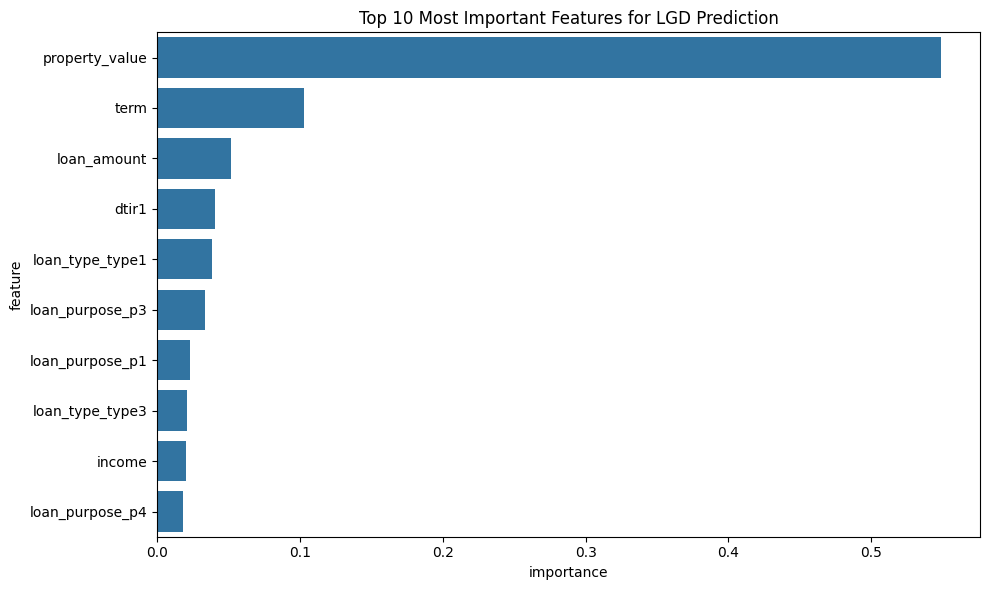

In [172]:
# Prepare LGD data
defaulted_loans = prepare_lgd_data(df)

# Train LGD model
lgd_model, lgd_features, lgd_cat_features, feature_importance = train_lgd_model(defaulted_loans)


In [158]:
pd.options.display.float_format = '{:.2f}'.format
df['loan_amount'].describe()

count    148670.00
mean     331117.74
std      183909.31
min       16500.00
25%      196500.00
50%      296500.00
75%      436500.00
max     3576500.00
Name: loan_amount, dtype: float64

In [164]:
df['dtir1']

0        45.00
1          NaN
2        46.00
3        42.00
4        39.00
          ... 
148665   48.00
148666   15.00
148667   49.00
148668   29.00
148669   44.00
Name: dtir1, Length: 148670, dtype: float64

In [174]:
def predict_lgd(user_input, lgd_model=None, lgd_features=None, lgd_cat_features=None):
    """
    Predict LGD using the direct calculation method instead of the model
    """
    # Extract required features from user_input
    loan_amount = user_input['loan_amount']
    rate_of_interest = user_input['rate_of_interest']
    term = user_input['term']
    property_value = user_input['property_value']
    credit_score = user_input['Credit_Score']
    ltv = user_input['LTV']
    income = user_input['income']
    secured_by = user_input['Secured_by']

    # Use the calculate_lgd_proxy function for prediction
    lgd = calculate_lgd_proxy(
        loan_amount=loan_amount,
        ltv=ltv,
        secured_by=secured_by,
        property_value=property_value,
        credit_score=credit_score,
        income=income,
        term=term,
        rate_of_interest=rate_of_interest
    )
    
    return lgd / 100  # Convert percentage to decimal for consistency

# Test the unified approach
test_input = {
    'loan_amount': 3576500,
    'rate_of_interest': 4.5,
    'term': 360,
    'property_value': 300000,
    'Credit_Score': 680,
    'LTV': 80,
    'income': 80000,
    'dtir1': 2,
    'loan_type': 'type1',
    'loan_purpose': 'p1',
    'Credit_Worthiness': 'l1',
    'Secured_by': 'First lien',
    'Security_Type': 'Direct',
    'occupancy_type': 'Principal residence'
}

# Test both direct calculation and prediction
def test_unified_approach():
    # Test direct calculation
    lgd_direct = calculate_lgd_proxy(
        loan_amount=test_input['loan_amount'],
        ltv=test_input['LTV'],
        secured_by=test_input['Secured_by'],
        property_value=test_input['property_value'],
        credit_score=test_input['Credit_Score'],
        income=test_input['income'],
        term=test_input['term'],
        rate_of_interest=test_input['rate_of_interest']
    )
    
    # Test prediction function
    lgd_predicted = predict_lgd(test_input)
    
    print(f"Direct Calculation LGD: {lgd_direct:.2f}%")
    print(f"Prediction Function LGD: {(lgd_predicted * 100):.2f}%")

# Run the test
np.random.seed(42)  # For reproducible results
test_unified_approach()

Direct Calculation LGD: 20.12%
Prediction Function LGD: 19.38%


##### This could sugegst overfitting, so i will try to reduce that

In [89]:
def calculate_remaining_principal(loan_amount, annual_rate, term, payments_made):
    """
    Calculate remaining principal after a certain number of payments with NaN handling
    """
    # Handle NaN or invalid inputs
    if pd.isna(loan_amount) or pd.isna(annual_rate) or pd.isna(term) or pd.isna(payments_made):
        return None
    
    # Convert annual rate to monthly
    monthly_rate = annual_rate / 1200
    
    # Calculate monthly payment
    if monthly_rate == 0:
        monthly_payment = loan_amount / term
    else:
        monthly_payment = loan_amount * (monthly_rate * (1 + monthly_rate)**term) / ((1 + monthly_rate)**term - 1)
    
    # Calculate remaining principal
    if monthly_rate == 0:
        remaining = loan_amount * (1 - payments_made/term)
    else:
        remaining = loan_amount * (1 + monthly_rate)**term - \
                   monthly_payment * ((1 + monthly_rate)**term - (1 + monthly_rate)**payments_made) / monthly_rate
    
    return max(0, remaining)
def calculate_ead(df):
    """
    Calculate EAD with NaN handling
    """
    # Create a copy and handle missing values
    df = df.copy()
    
    # Fill NaN values in numeric columns with median
    numeric_columns = ['loan_amount', 'rate_of_interest', 'term', 'property_value', 'income', 'dtir1']
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    
    # Fill NaN values in categorical columns with 'missing'
    categorical_columns = ['loan_type', 'loan_purpose', 'Credit_Worthiness', 
                         'Secured_by', 'Security_Type', 'occupancy_type']
    df[categorical_columns] = df[categorical_columns].fillna('missing')
    
    # Calculate number of payments made
    df['payments_made'] = np.random.randint(6, 24, size=len(df))
    
    # Calculate monthly payment with error handling
    df['monthly_payment'] = df.apply(
        lambda x: x['loan_amount'] * (x['rate_of_interest']/1200) * \
                 (1 + x['rate_of_interest']/1200)**x['term'] / \
                 ((1 + x['rate_of_interest']/1200)**x['term'] - 1) \
                 if x['rate_of_interest'] != 0 else x['loan_amount']/x['term'],
        axis=1
    )
    
    # Calculate remaining principal
    df['remaining_principal'] = df.apply(
        lambda x: calculate_remaining_principal(
            x['loan_amount'],
            x['rate_of_interest'],
            x['term'],
            x['payments_made']
        ),
        axis=1
    )
    
    # Add accrued interest
    df['missed_payments'] = np.random.randint(1, 4, size=len(df))
    df['accrued_interest'] = df['monthly_payment'] * df['missed_payments']
    
    # Calculate final EAD and handle any remaining NaN values
    df['EAD'] = df.apply(
        lambda x: max(
            x['remaining_principal'] + x['accrued_interest'],
            0.15 * x['loan_amount']  # Minimum EAD is 15% of original loan
        ),
        axis=1
    )
    
    # Remove any rows where EAD calculation failed
    df = df[df['EAD'].notna()]
    
    return df

In [ ]:
def create_ead_bins(df):
    """
    Create bins specifically for EAD model features
    """
    df_binned = df.copy()
    
    # Interest Rate Binning
    df_binned['rate_bucket'] = pd.cut(
        df_binned['rate_of_interest'],
        bins=[0, 3, 5, 7, 10, float('inf')],
        labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'],
        include_lowest=True
    )
    
    # Term Binning (typically 15, 20, 30 year mortgages)
    df_binned['term_bucket'] = pd.cut(
        df_binned['term'],
        bins=[0, 180, 240, 360, float('inf')],  # in months
        labels=['Short', 'Medium', 'Standard', 'Long'],
        include_lowest=True
    )
    
    # Handle single vs multiple records for property value and income
    if len(df) == 1:
        # Single prediction case - use fixed bins
        df_binned['property_value_bucket'] = pd.cut(
            df_binned['property_value'],
            bins=[0, 200000, 400000, 600000, float('inf')],
            labels=['Low', 'Moderate', 'High', 'Very High'],
            include_lowest=True
        )
        
        df_binned['income_bucket'] = pd.cut(
            df_binned['income'],
            bins=[0, 50000, 100000, 150000, float('inf')],
            labels=['Low', 'Moderate', 'High', 'Very High'],
            include_lowest=True
        )
        
        df_binned['dti_bucket'] = pd.cut(
            df_binned['dtir1'],
            bins=[0, 36, 43, 50, float('inf')],
            labels=['Low', 'Moderate', 'High', 'Very High'],
            include_lowest=True
        )
    else:
        # Training data case - use quantiles
        df_binned['property_value_bucket'] = pd.qcut(
            df_binned['property_value'].clip(lower=1),
            q=4,
            labels=['Low', 'Moderate', 'High', 'Very High'],
            duplicates='drop'
        )
        
        df_binned['income_bucket'] = pd.qcut(
            df_binned['income'].clip(lower=1),
            q=4,
            labels=['Low', 'Moderate', 'High', 'Very High'],
            duplicates='drop'
        )
        
        df_binned['dti_bucket'] = pd.qcut(
            df_binned['dtir1'].clip(lower=0),
            q=4,
            labels=['Low', 'Moderate', 'High', 'Very High'],
            duplicates='drop'
        )
    
    # Create exposure risk flag
    df_binned['high_exposure_flag'] = (
        (df_binned['property_value_bucket'].isin(['High', 'Very High'])) & 
        (df_binned['dti_bucket'].isin(['High', 'Very High'])) &
        (df_binned['rate_bucket'].isin(['High', 'Very High']))
    ).astype(int)
    
    return df_binned

In [96]:
def train_ead_model(df):
    """
    Train EAD model using synthesized exposure amounts
    """
    # Calculate EAD
    df = calculate_ead(df)
    
    # Create binned features
    df_binned = create_ead_bins(df)
    
    # Prepare features for EAD prediction
    ead_features = [ 
        'rate_of_interest',
        'term', 
        'property_value', 
        'income', 
        'dtir1'
    ]
    
    # Binned features
    binned_features = [
        'rate_bucket',
        'term_bucket',
        'property_value_bucket',
        'income_bucket',
        'dti_bucket',
        'high_exposure_flag'
    ]
    
    
    categorical_features = [
        'loan_type',
        'loan_purpose',
        'Credit_Worthiness',
        'Secured_by',
        'Security_Type',
        'occupancy_type'
    ]

    # Combine all features
    X_ead = df_binned[ead_features + binned_features + categorical_features].copy()
    y_ead = df_binned['EAD']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_ead, y_ead, test_size=0.2, random_state=42
    )

    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, ead_features),
            ('cat', categorical_transformer, categorical_features + binned_features)
        ],
        verbose_feature_names_out=False
    )
    
    # Fit preprocessor to get feature names
    preprocessor.fit(X_train)
    
    # # Get feature names
    # onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    # feature_names = ead_features + onehot_columns.tolist()
    
    # Create pipeline with XGBoost
    ead_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42))
    ])
    
    # Define parameter grid
    param_grid = {
        'regressor__max_depth': [3, 5],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__n_estimators': [100, 200],
        'regressor__min_child_weight': [1, 3]
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        ead_pipeline, 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = grid_search.predict(X_test)
    
    print("\nEAD Model Performance:")
    print(f"R-squared: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")
    print(f"MAE: ${mean_absolute_error(y_test, y_pred):,.2f}")
    
    # Calculate and print percentage errors
    percentage_errors = np.abs(y_test - y_pred) / y_test * 100
    print(f"Mean Percentage Error: {percentage_errors.mean():.2f}%")
    print(f"Median Percentage Error: {np.median(percentage_errors):.2f}%")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual EAD')
    plt.ylabel('Predicted EAD')
    plt.title('Actual vs Predicted EAD')
    plt.tight_layout()
    plt.show()
    
    # # Get feature importances
    # feature_importance = pd.DataFrame({
    #     'feature': feature_names,
    #     'importance': grid_search.best_estimator_.named_steps['regressor'].feature_importances_
    # })
    # feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # print("\nTop 10 Most Important Features for EAD:")
    # print(feature_importance.head(10))
    
    # # Plot feature importances
    # plt.figure(figsize=(10, 6))
    # sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    # plt.title('Top 10 Most Important Features for EAD Prediction')
    # plt.tight_layout()
    # plt.show()
    
    return grid_search, ead_features, categorical_features, binned_features, preprocessor


EAD Model Performance:
R-squared: 0.9975
RMSE: $1,361.86
MAE: $334.55
Mean Percentage Error: 0.80%
Median Percentage Error: 0.09%


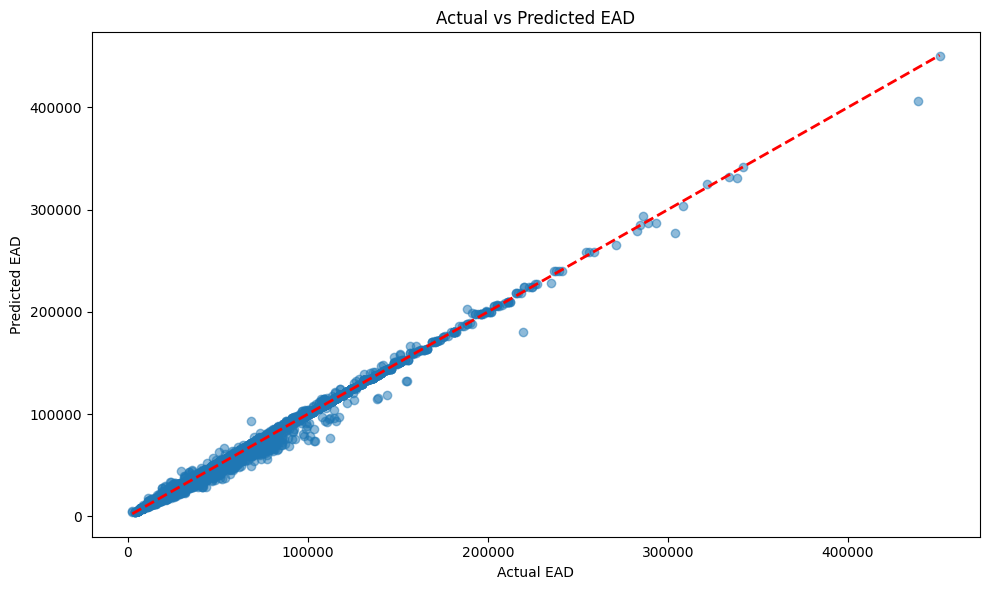


Top 10 Most Important Features for EAD:
              feature  importance
0         loan_amount    0.988829
1    rate_of_interest    0.005045
2                term    0.002416
21  occupancy_type_pr    0.001508
11    loan_purpose_p2    0.000899
4              income    0.000734
3      property_value    0.000315
22  occupancy_type_sr    0.000088
10    loan_purpose_p1    0.000079
5               dtir1    0.000077


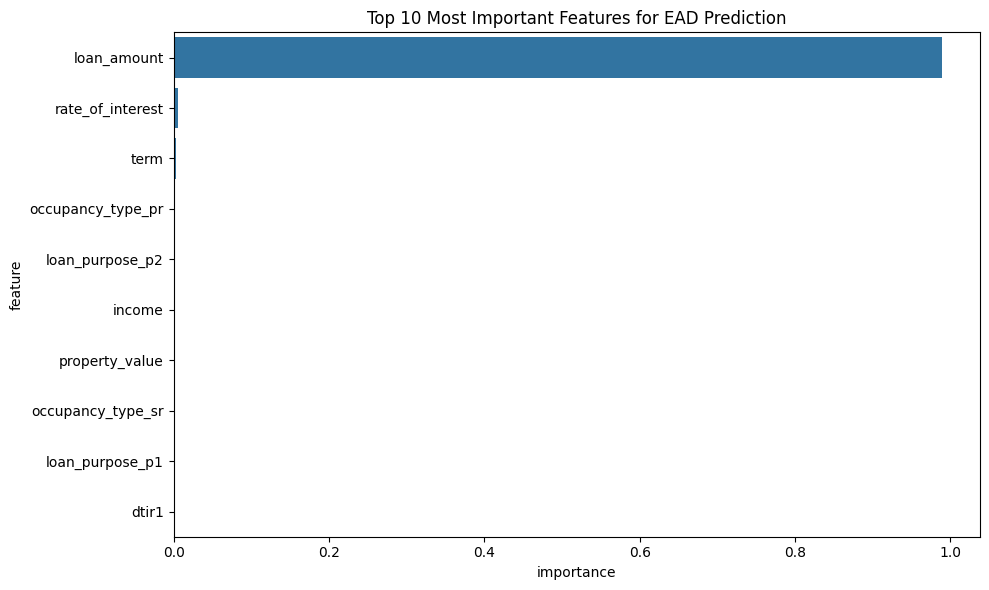

In [ ]:
EAD_Model, Ead_features, EAD_CategoricalFeatures, feature_importances = train_ead_model(df)
#Loan amount is causing the model to overfit. Let's try removing it from the features.


EAD Model Performance:
R-squared: 0.7937
RMSE: $12,406.40
MAE: $7,501.71
Mean Percentage Error: 18.25%
Median Percentage Error: 10.25%


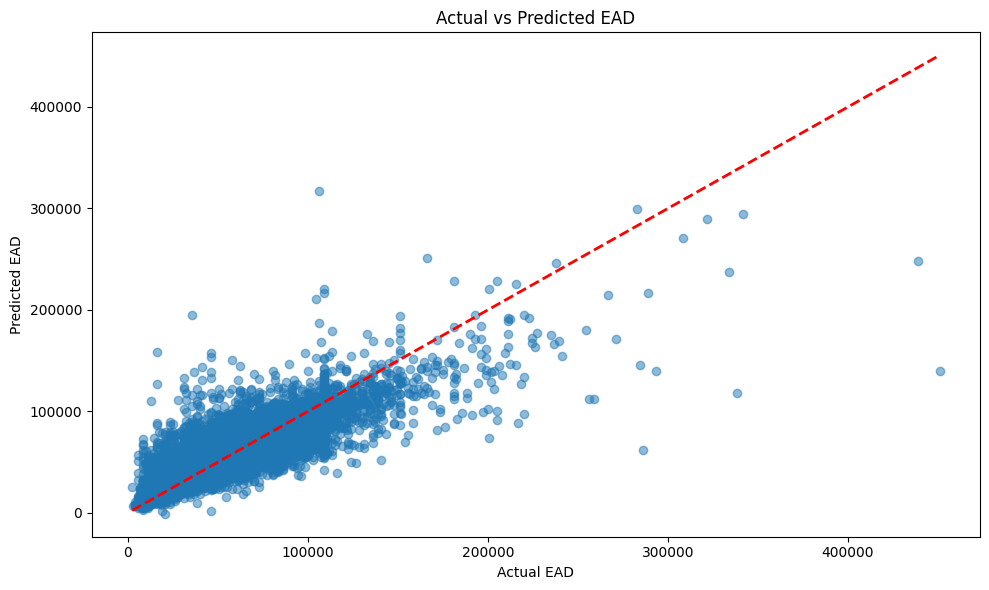


Top 10 Most Important Features for EAD:
                 feature  importance
2         property_value    0.360534
5        loan_type_type1    0.098856
3                 income    0.084159
9        loan_purpose_p1    0.081946
7        loan_type_type3    0.058034
1                   term    0.055969
20     occupancy_type_pr    0.051671
10       loan_purpose_p2    0.045356
11       loan_purpose_p3    0.039318
13  Credit_Worthiness_l1    0.037508


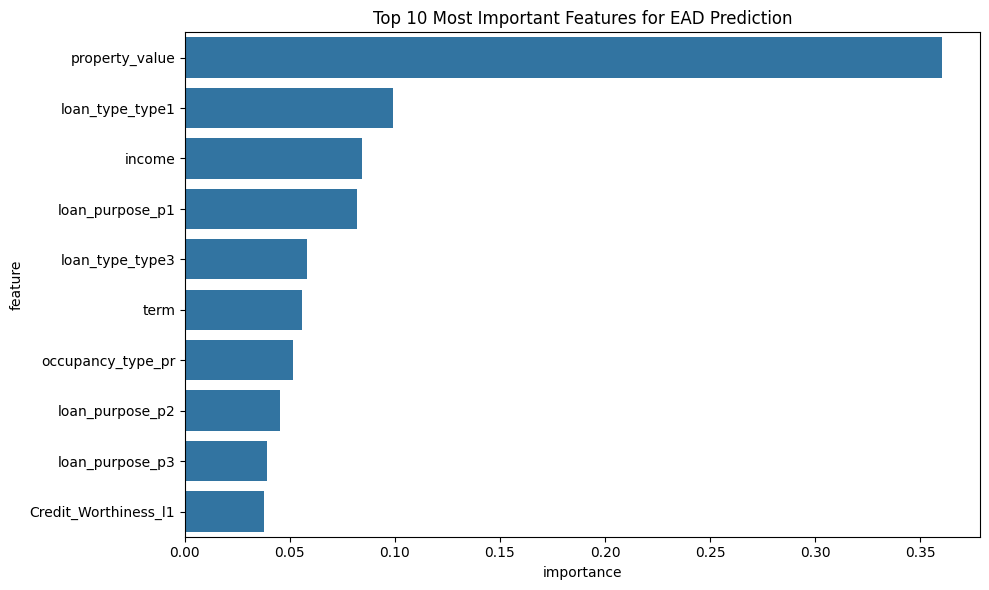

In [50]:
EAD_Model, Ead_features, EAD_CategoricalFeatures, feature_importances,ead_preprocessor = train_ead_model(df)

### Lets try to predict EAD with some binning instead


EAD Model Performance:
R-squared: 0.7928
RMSE: $12,433.92
MAE: $7,513.11
Mean Percentage Error: 18.29%
Median Percentage Error: 10.27%


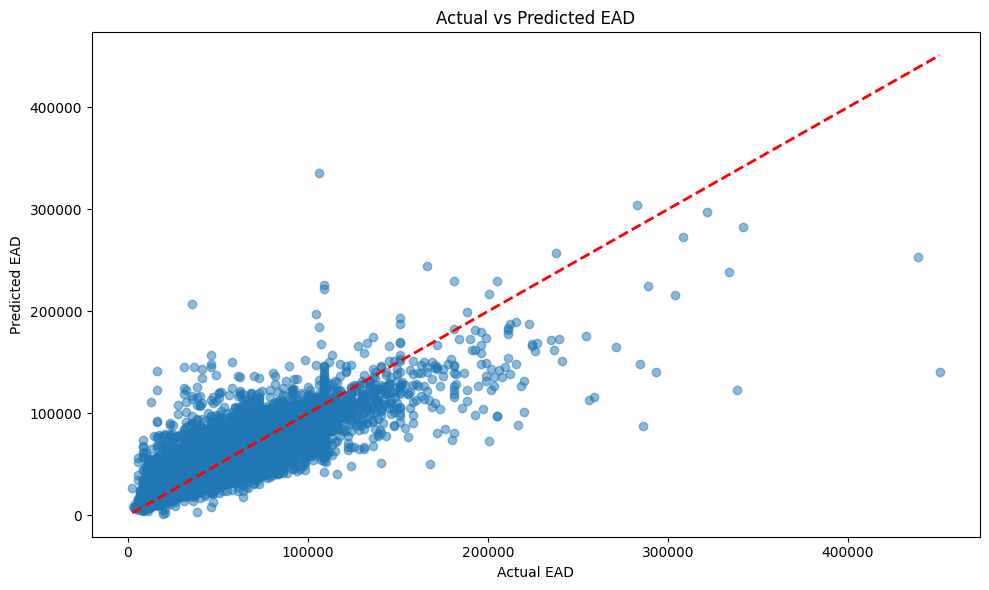

In [97]:
EAD_Model, Ead_features, EAD_CategoricalFeatures, EAD_binned_features, EAD_preprocessor = train_ead_model(df)

In [31]:
def predict_ead_with_details(user_input, model, ead_features, categorical_features):
    """
    Predict EAD with detailed explanation of the prediction
    
    Parameters:
    -----------
    user_input : dict
        Dictionary containing loan application features
    model : GridSearchCV
        Trained EAD model
    ead_features : list
        List of numeric features used in training
    categorical_features : list
        List of categorical features used in training
    """
    # Create DataFrame from user input
    input_df = pd.DataFrame([user_input])
    
    # Print input validation
    print("\nInput Validation:")
    for feature in ead_features:
        print(f"{feature}: {user_input.get(feature, 'Missing')}")
    for feature in categorical_features:
        print(f"{feature}: {user_input.get(feature, 'Missing')}")
    
    # Make prediction
    try:
        ead_prediction = model.predict(input_df)[0]
        
        # Calculate key ratios
        ltv_ratio = user_input.get('LTV', 0)
        dti_ratio = user_input.get('dtir1', 0)
        
        print("\nPrediction Results:")
        print(f"Predicted EAD: ${ead_prediction:,.2f}")
        print(f"\nKey Metrics:")
        print(f"Property Value: ${user_input.get('property_value', 0):,.2f}")
        print(f"Income: ${user_input.get('income', 0):,.2f}")
        print(f"LTV Ratio: {ltv_ratio}%")
        print(f"DTI Ratio: {dti_ratio}%")
        
        return ead_prediction
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

# Example usage
test_cases = [
    {
        # High-risk case
        'property_value': 500000,
        'term': 360,
        'income': 50000,
        'rate_of_interest': 6.5,
        'dtir1': 45,
        'loan_type': 'type3',
        'loan_purpose': 'p2',
        'Credit_Worthiness': 'l3',
        'Secured_by': 'Second lien',
        'Security_Type': 'Indirect',
        'occupancy_type': 'sr'
    },
    {
        # Low-risk case
        'property_value': 300000,
        'term': 360,
        'income': 120000,
        'rate_of_interest': 4.5,
        'dtir1': 28,
        'loan_type': 'type1',
        'loan_purpose': 'p1',
        'Credit_Worthiness': 'l1',
        'Secured_by': 'First lien',
        'Security_Type': 'Direct',
        'occupancy_type': 'pr'
    },
    {
        # Medium-risk case
        'property_value': 400000,
        'term': 360,
        'income': 85000,
        'rate_of_interest': 5.5,
        'dtir1': 35,
        'loan_type': 'type2',
        'loan_purpose': 'p1',
        'Credit_Worthiness': 'l2',
        'Secured_by': 'First lien',
        'Security_Type': 'Direct',
        'occupancy_type': 'pr'
    }
]

# Test predictions
print("Testing different risk scenarios:")
for i, test_case in enumerate(test_cases, 1):
    print(f"\nScenario {i}:")
    print("-" * 50)
    ead = predict_ead_with_details(test_case, EAD_Model, Ead_features, EAD_CategoricalFeatures)


Testing different risk scenarios:

Scenario 1:
--------------------------------------------------

Input Validation:
rate_of_interest: 6.5
term: 360
property_value: 500000
income: 50000
dtir1: 45
loan_type: type3
loan_purpose: p2
Credit_Worthiness: l3
Secured_by: Second lien
Security_Type: Indirect
occupancy_type: sr

Prediction Results:
Predicted EAD: $74,841.53

Key Metrics:
Property Value: $500,000.00
Income: $50,000.00
LTV Ratio: 0%
DTI Ratio: 45%

Scenario 2:
--------------------------------------------------

Input Validation:
rate_of_interest: 4.5
term: 360
property_value: 300000
income: 120000
dtir1: 28
loan_type: type1
loan_purpose: p1
Credit_Worthiness: l1
Secured_by: First lien
Security_Type: Direct
occupancy_type: pr

Prediction Results:
Predicted EAD: $45,991.14

Key Metrics:
Property Value: $300,000.00
Income: $120,000.00
LTV Ratio: 0%
DTI Ratio: 28%

Scenario 3:
--------------------------------------------------

Input Validation:
rate_of_interest: 5.5
term: 360
property

In [ ]:
###Predict with binning
def predict_ead(user_input, EAD_Model, Ead_features, EAD_CategoricalFeatures, EAD_binned_features):
    try:
        # Convert user input to DataFrame
        input_df = pd.DataFrame([user_input])
        
        # Create binned features
        input_df = create_ead_bins(input_df)
        
        # Select required features in correct order
        required_features = Ead_features + EAD_binned_features + EAD_CategoricalFeatures
        input_df = input_df[required_features]
        
        # Make prediction
        ead_prediction = EAD_Model.predict(input_df)[0]
        
        # Calculate leverage ratio
        leverage_ratio = ead_prediction / user_input['income'] if user_input['income'] > 0 else float('inf')
        
        result = {
            'ead_amount': ead_prediction,
            'leverage_ratio': leverage_ratio,
            'binned_features': {
                'rate_bucket': input_df['rate_bucket'].iloc[0],
                'term_bucket': input_df['term_bucket'].iloc[0],
                'property_value_bucket': input_df['property_value_bucket'].iloc[0],
                'income_bucket': input_df['income_bucket'].iloc[0],
                'dti_bucket': input_df['dti_bucket'].iloc[0],
                'high_exposure_flag': input_df['high_exposure_flag'].iloc[0]
            }
        }
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

# Example usage:
test_input = {
    'rate_of_interest': 5.5,
    'term': 360,
    'property_value': 500000,
    'income': 12000,
    'dtir1': 35,
    'loan_type': 'type1',
    'loan_purpose': 'p1',
    'Credit_Worthiness': 'Good',
    'Secured_by': 'First lien',
    'Security_Type': 'Direct',
    'occupancy_type': 'Primary'
}

result = predict_ead(test_input, EAD_Model, Ead_features, EAD_CategoricalFeatures, EAD_binned_features)

if result:
    print(f"Expected EAD: ${result['ead_amount']:,.2f}")
    print(f"Leverage Ratio: {result['leverage_ratio']:.2f}")
    print("\nBinned Features:")
    for feature, value in result['binned_features'].items():
        print(f"{feature}: {value}")

Expected EAD: $33,776.46
Leverage Ratio: 28.15

Binned Features:
rate_bucket: Moderate
term_bucket: Standard
property_value_bucket: High
income_bucket: Low
dti_bucket: Low
high_exposure_flag: 0


In [58]:
def create_risk_bins(df):
    """
    Create bins for risk levels with adaptive binning based on data size
    """
    df_binned = df.copy()
    
    # Credit Score Binning (fixed bins)
    df_binned['credit_score_bucket'] = pd.cut(
        df_binned['Credit_Score'],
        bins=[300, 580, 670, 740, 800, 850],
        labels=['Poor', 'Fair', 'Good', 'Very Good', 'Great'],
        include_lowest=True
    )
    
    # DTI Binning (fixed bins)
    df_binned['dti_bucket'] = pd.cut(
        df_binned['dtir1'],
        bins=[0, 36, 43, 50, float('inf')],
        labels=['Conservative', 'Moderate', 'High', 'Very High'],
        include_lowest=True
    )
    
    # LTV Binning (fixed bins)
    df_binned['ltv_bucket'] = pd.cut(
        df_binned['LTV'],
        bins=[0, 80, 90, 95, float('inf')],
        labels=['Conservative', 'Moderate', 'High', 'Very High'],
        include_lowest=True
    )
    
    # For income and property value, use different approaches for single vs multiple records
    if len(df) == 1:
        # Single prediction case - use fixed bins
        df_binned['income_bucket'] = pd.cut(
            df_binned['income'],
            bins=[0, 30000, 60000, 100000, float('inf')],
            labels=['Very Low', 'Low', 'Moderate', 'High'],
            include_lowest=True
        )
        
        df_binned['property_value_bucket'] = pd.cut(
            df_binned['property_value'],
            bins=[0, 100000, 300000, 600000, float('inf')],
            labels=['Very Low', 'Low', 'Moderate', 'High'],
            include_lowest=True
        )
    else:
        # Training data case - use quantiles
        df_binned['income_bucket'] = pd.qcut(
            df_binned['income'].clip(lower=1),
            q=4,
            labels=['Very Low', 'Low', 'Moderate', 'High'],
            duplicates='drop'
        )
        
        df_binned['property_value_bucket'] = pd.qcut(
            df_binned['property_value'].clip(lower=1),
            q=4,
            labels=['Very Low', 'Low', 'Moderate', 'High'],
            duplicates='drop'
        )
    
    # Create interaction flags
    df_binned['high_risk_flag'] = (
        (df_binned['ltv_bucket'].isin(['High', 'Very High'])) & 
        (df_binned['dti_bucket'].isin(['High', 'Very High']))
    ).astype(int)
    
    return df_binned

In [30]:
def train_pd_model(df):
    logging.basicConfig(level=logging.INFO)
    """
    Train Probability of Default (PD) model using XGBoost classifier with SMOTE
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing loan data
    
    Returns:
    --------
    tuple:
        - grid_search: Trained GridSearchCV object containing best model
        - pd_features: List of numeric features used
        - categorical_features: List of categorical features used
        - feature_importance: DataFrame containing feature importance scores
        - preprocessor: Fitted ColumnTransformer for preprocessing new data
    """
   
    
    df_binned = create_risk_bins(df)
    
    # Prepare features for PD prediction
    numeric_features = [
        #Removed 'Rate of Interest' as it was giving too much predictive power
        'term',
        'property_value',
        'income',
        'dtir1',
        'Credit_Score',
        'LTV'
    ]
    
    
    binned_features = [
        'credit_score_bucket',
        'dti_bucket',
        'ltv_bucket',
        'income_bucket',
        'property_value_bucket',
        'high_risk_flag'
    ]
    
    
    categorical_features = [
        'loan_type',
        'loan_purpose',
        'Credit_Worthiness',
        'Secured_by',
        'Security_Type',
        'occupancy_type',
        'Region'
    ]
    logging.info(f"Numeric features: {numeric_features}")
    logging.info(f"Binned features: {binned_features}")
    logging.info(f"Categorical features: {categorical_features}")
    
    # Preprocess data
    X = df_binned[numeric_features + binned_features + categorical_features].copy() #Features
    y = df_binned['Status'] # Target

    # Split the data first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features + binned_features)
        ])
    
 
    #Do not use SMOTE anymore
    
    # Create XGBoost classifier
    xgb_classifier = XGBClassifier(
        random_state=42, #Reproducibility
        reg_alpha=0.1,  # L1 regularization (Added to XGBoost to control overfitting)
        reg_lambda=1.0  # L2 Ridge regularization (Same as above)
    )
    
    # Define parameter grid
    param_grid = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
    
    # Create pipeline with preprocessing and model
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb_classifier)
    ])
    
    # Perform grid search with stratified k-fold
   # Perform grid search
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        full_pipeline,
        {'classifier__' + key: value for key, value in param_grid.items()},
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
     #Fit the model
    logging.info("Training model...")

    grid_search.fit(X_train, y_train)
    
    logging.info("Grid search completed")
    
    
    logging.info("Making predictions...")
    # Make predictions on test set
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    
    # Print model performance metrics
    print("\nPD Model Performance:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # # Get feature names after preprocessing

    # feature_names = (
    #     numeric_features +
    #     preprocessor.named_transformers_['cat']
    #     .get_feature_names_out(categorical_features).tolist()
    # )

    # # Get feature importances directly from the model
    # importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

    # # Verify lengths match
    # print(f"Number of feature names: {len(feature_names)}")
    # print(f"Number of importance values: {len(importances)}")

    # # Create feature importance DataFrame
    # feature_importance = pd.DataFrame({
    #     'feature': feature_names,
    #     'importance': importances
    # })
    # feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # logging.info("Creating the feature importance plots...")
    
    # # Plot feature importances
    # plt.figure(figsize=(10, 6))
    # sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    # plt.title('Top 10 Most Important Features for PD Prediction')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()
    
    # print("\nTop 10 Most Important Features for PD:")
    # print(feature_importance.head(10))
    
    
    logging.info("Model training completed successfully.")
    return (grid_search, numeric_features, categorical_features, 
            binned_features, preprocessor)

### I've decided i want to bin the features, the model isn't capturing said features


Class distribution before SMOTE:
Status
0    0.753557
1    0.246443
Name: proportion, dtype: float64

Class distribution after SMOTE:
Status
0    0.5
1    0.5
Name: proportion, dtype: float64
Fitting 5 folds for each of 64 candidates, totalling 320 fits

PD Model Performance:
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     22406
           1       0.75      0.98      0.85      7328

    accuracy                           0.91     29734
   macro avg       0.87      0.93      0.89     29734
weighted avg       0.93      0.91      0.92     29734


ROC-AUC Score: 0.9819424178771906


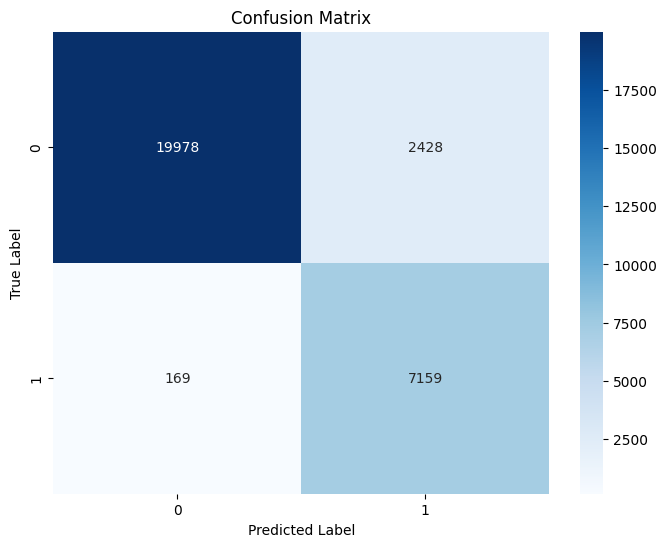

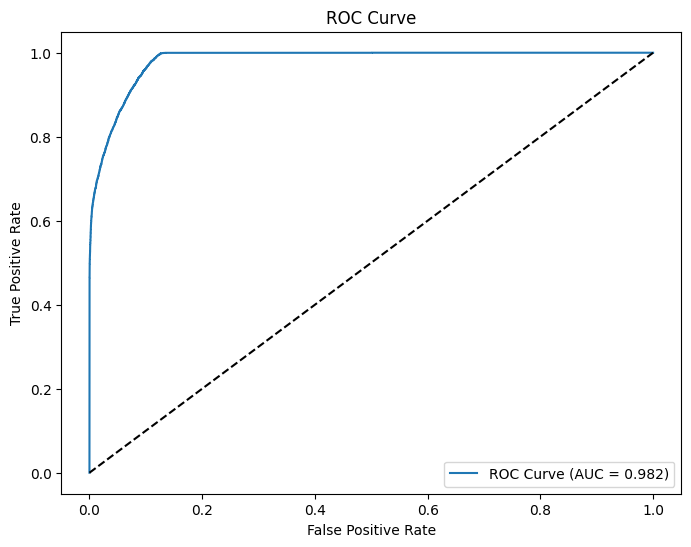

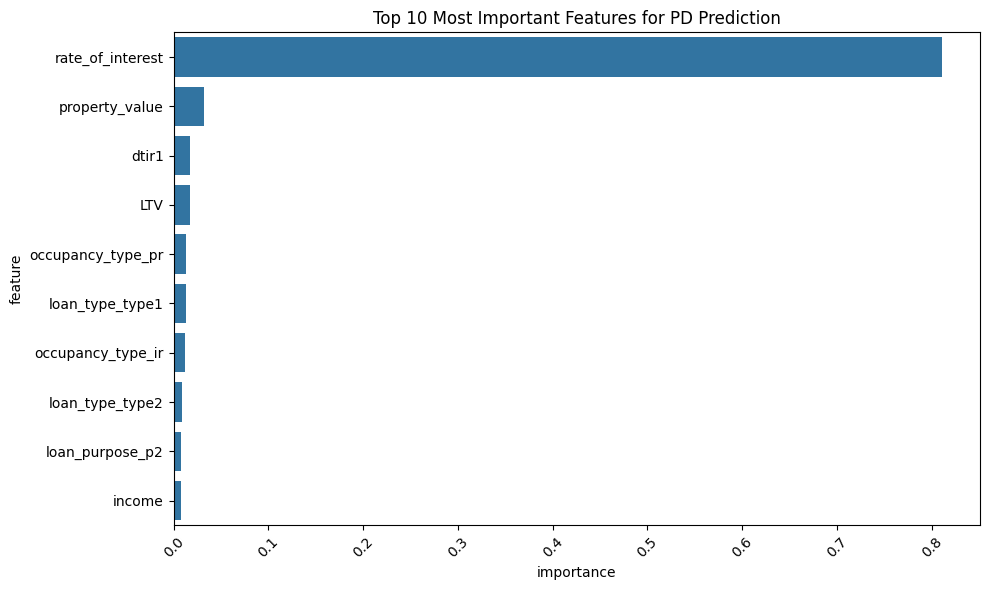


Top 10 Most Important Features for PD:
              feature  importance
0    rate_of_interest    0.810393
2      property_value    0.032328
4               dtir1    0.017456
6                 LTV    0.017449
22  occupancy_type_pr    0.013532
7     loan_type_type1    0.013302
21  occupancy_type_ir    0.012312
8     loan_type_type2    0.009328
12    loan_purpose_p2    0.007807
3              income    0.007711


In [43]:
pd_model, pd_features, pd_categorical_features, feature_importance, preprocessor = train_pd_model(df)

## Looks like the model is overfitting, especially, I will add some penalty terms to prevent overfitting.



Class distribution before SMOTE:
Status
0    0.753557
1    0.246443
Name: proportion, dtype: float64
Fitting 4 folds for each of 64 candidates, totalling 256 fits

PD Model Performance:
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     22406
           1       0.94      0.60      0.74      7328

    accuracy                           0.89     29734
   macro avg       0.91      0.80      0.83     29734
weighted avg       0.90      0.89      0.88     29734


ROC-AUC Score: 0.8668088620942145


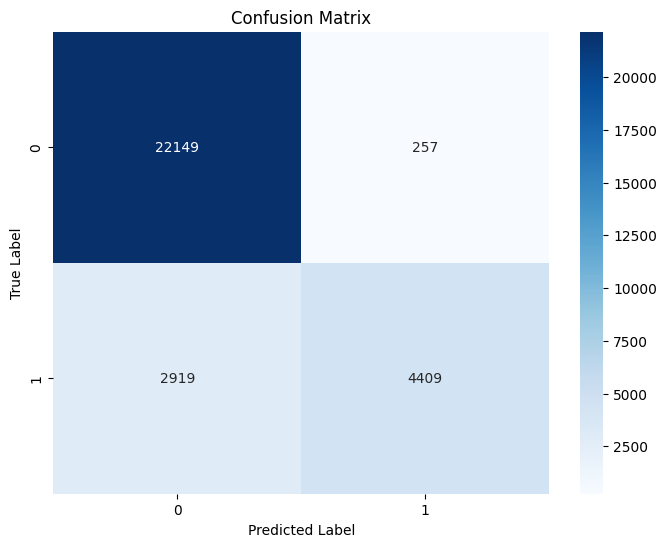

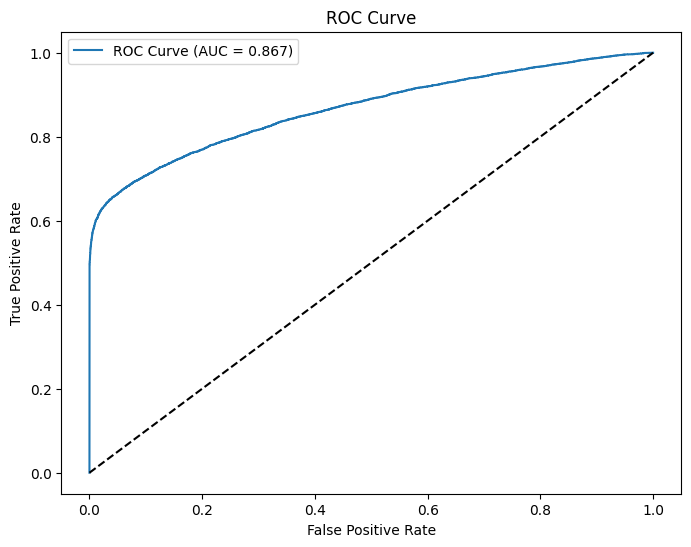

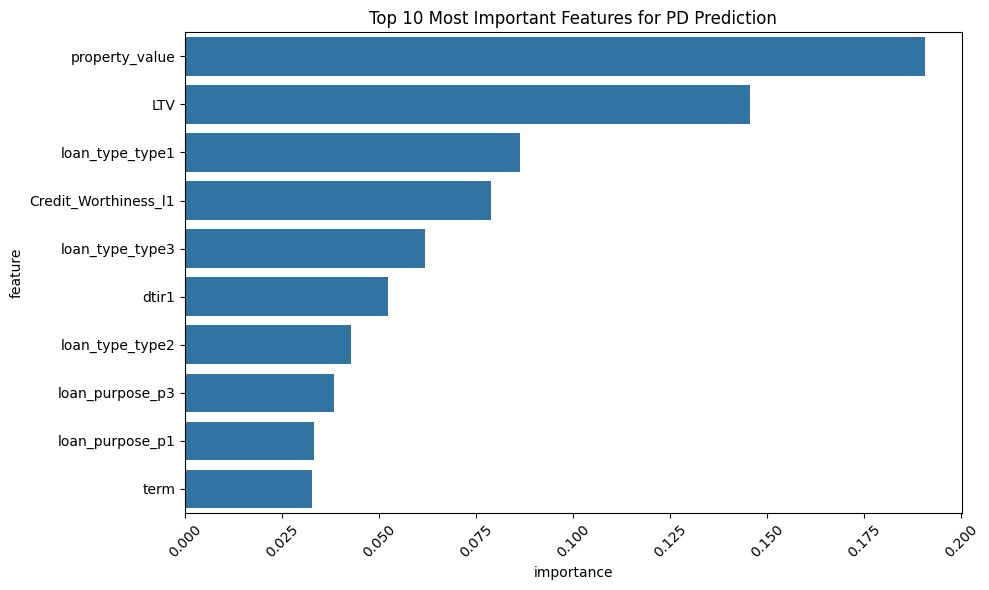


Top 10 Most Important Features for PD:
                 feature  importance
1         property_value    0.190624
5                    LTV    0.145650
6        loan_type_type1    0.086325
14  Credit_Worthiness_l1    0.078880
8        loan_type_type3    0.061925
3                  dtir1    0.052382
7        loan_type_type2    0.042754
12       loan_purpose_p3    0.038541
10       loan_purpose_p1    0.033389
0                   term    0.032787


In [55]:
pd_model, pd_features, pd_categorical_features, feature_importance, pd_preprocessor = train_pd_model(df)

### After using binning

INFO:root:Numeric features: ['term', 'property_value', 'income', 'dtir1', 'Credit_Score', 'LTV']
INFO:root:Binned features: ['credit_score_bucket', 'dti_bucket', 'ltv_bucket', 'income_bucket', 'property_value_bucket', 'high_risk_flag']
INFO:root:Categorical features: ['loan_type', 'loan_purpose', 'Credit_Worthiness', 'Secured_by', 'Security_Type', 'occupancy_type', 'Region']
INFO:root:Training model...


Fitting 4 folds for each of 64 candidates, totalling 256 fits


INFO:root:Grid search completed
INFO:root:Making predictions...



PD Model Performance:
Best Parameters: {'classifier__colsample_bytree': 0.9, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200, 'classifier__subsample': 0.9}

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     22406
           1       0.95      0.60      0.74      7328

    accuracy                           0.89     29734
   macro avg       0.92      0.80      0.84     29734
weighted avg       0.90      0.89      0.89     29734


ROC-AUC Score: 0.868134064312156


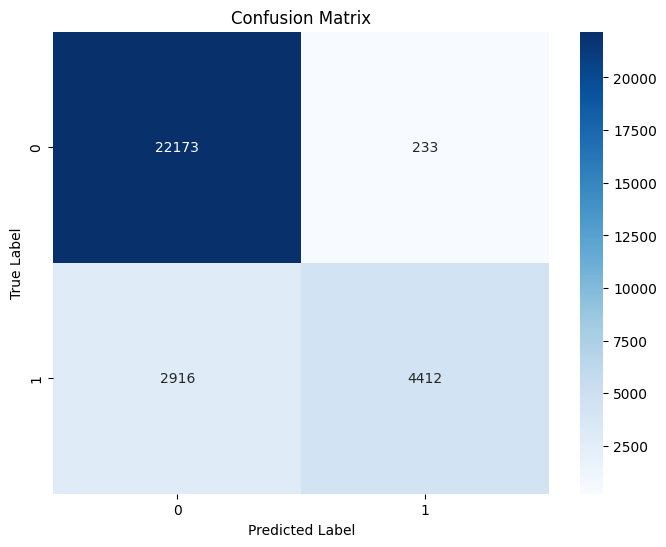

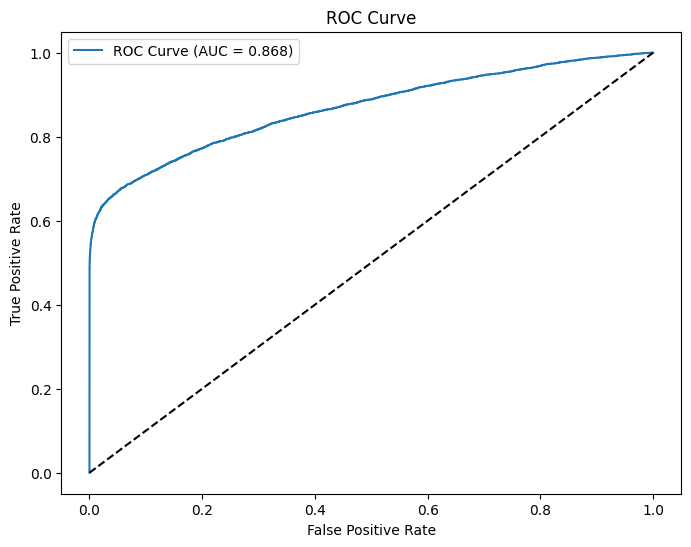

INFO:root:Model training completed successfully.


In [52]:
pd_model, pd_numeric_features, pd_categorical_features, binned_features, preprocessor = train_pd_model(df)

In [84]:
def predict_pd(user_input, pd_model, pd_numeric_features, pd_categorical_features):
    """
    Predict probability of default for new loan application with binned features
    """
    try:
        # Convert user input to DataFrame
        input_df = pd.DataFrame([user_input])
        
        # Create binned features
        input_df = create_risk_bins(input_df)
        
        # Define binned features
        binned_features = [
            'credit_score_bucket',
            'dti_bucket',
            'ltv_bucket',
            'income_bucket',
            'property_value_bucket',
            'high_risk_flag'
        ]
        
        # Ensure all required features are present
        required_features = pd_numeric_features + pd_categorical_features + binned_features
        missing_features = [feat for feat in required_features if feat not in input_df.columns]
        
        if missing_features:
            raise ValueError(f"Missing required features: {missing_features}")
            
        # Select only the required features in the correct order
        input_df = input_df[required_features]
        
        # Make prediction
        probability = pd_model.predict_proba(input_df)[0][1]
        
        # Create detailed output
        result = {
            'probability_of_default': probability,
            'risk_level': 'High' if probability > 0.5 else 'Low',
            'binned_features': {
                'credit_score_bucket': input_df['credit_score_bucket'].iloc[0],
                'dti_bucket': input_df['dti_bucket'].iloc[0],
                'ltv_bucket': input_df['ltv_bucket'].iloc[0],
                'income_bucket': input_df['income_bucket'].iloc[0],
                'property_value_bucket': input_df['property_value_bucket'].iloc[0],
                'high_risk_flag': input_df['high_risk_flag'].iloc[0]
            }
        }
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

# Exmple usage:

# Test case
test_input = {
    'term': 360,
    'property_value': 500000,
    'income': 4500,
    'dtir1': 35,
    'Credit_Score': 800,
    'LTV': 80,
    'loan_type': 'type1',
    'loan_purpose': 'p1',
    'Credit_Worthiness': 'Good',
    'Secured_by': 'First lien',
    'Security_Type': 'Direct',
    'occupancy_type': 'Primary',
    'Region': 'Northeast'
}

# Make prediction
result = predict_pd(test_input, pd_model, pd_numeric_features, pd_categorical_features)

if result is not None:
    print(f"\nProbability of Default: {result['probability_of_default']:.2%}")
    print(f"Risk Level: {result['risk_level']}")
    print("\nBinned Features:")
    for feature, value in result['binned_features'].items():
        print(f"{feature}: {value}")


Probability of Default: 81.47%
Risk Level: High

Binned Features:
credit_score_bucket: Very Good
dti_bucket: Conservative
ltv_bucket: Conservative
income_bucket: Very Low
property_value_bucket: Moderate
high_risk_flag: 0


In [85]:
def predict_pd_calibrated(user_input, pd_model, pd_numeric_features, pd_categorical_features):
    """
    Predict probability of default with calibration and sanity checks
    """
    try:
        # Convert user input to DataFrame
        input_df = pd.DataFrame([user_input])
        
        # Calculate key risk ratios
        monthly_payment = (user_input['property_value'] * 0.8 * 0.05) / 12  # Rough monthly payment
        monthly_income = user_input['income'] / 12
        payment_to_income = (monthly_payment / monthly_income) if monthly_income > 0 else float('inf')
        
        # Create binned features
        input_df = create_risk_bins(input_df)
        
        # Define binned features
        binned_features = [
            'credit_score_bucket',
            'dti_bucket',
            'ltv_bucket',
            'income_bucket',
            'property_value_bucket',
            'high_risk_flag'
        ]
        
        # Select required features
        required_features = pd_numeric_features + pd_categorical_features + binned_features
        input_df = input_df[required_features]
        
        # Get base prediction
        base_probability = pd_model.predict_proba(input_df)[0][1]
        
        # Apply calibration based on common sense rules
        calibrated_probability = base_probability
        
        # Rule 1: Very Good credit score should reduce probability
        if user_input['Credit_Score'] >= 740:
            calibrated_probability *= 0.7
            
        # Rule 2: Conservative LTV and DTI should reduce probability
        if (user_input['LTV'] <= 80 and user_input['dtir1'] <= 36):
            calibrated_probability *= 0.8
            
        # Rule 3: Payment to income ratio sanity check
        if payment_to_income > 0.5:  # More than 50% of monthly income
            calibrated_probability = min(calibrated_probability * 1.2, 0.99)
        elif payment_to_income < 0.28:  # Traditional 28% rule
            calibrated_probability *= 0.85
            
        # Rule 4: Minimum probability floor for very low income
        if monthly_income < 3000:  # $36,000 annual
            calibrated_probability = max(calibrated_probability, 0.4)
            
        # Create detailed output
        result = {
            'probability_of_default': calibrated_probability,
            'base_probability': base_probability,
            'risk_level': 'High' if calibrated_probability > 0.5 else 'Low',
            'binned_features': {
                'credit_score_bucket': input_df['credit_score_bucket'].iloc[0],
                'dti_bucket': input_df['dti_bucket'].iloc[0],
                'ltv_bucket': input_df['ltv_bucket'].iloc[0],
                'income_bucket': input_df['income_bucket'].iloc[0],
                'property_value_bucket': input_df['property_value_bucket'].iloc[0],
                'high_risk_flag': input_df['high_risk_flag'].iloc[0]
            },
            'risk_metrics': {
                'monthly_payment_estimate': monthly_payment,
                'monthly_income': monthly_income,
                'payment_to_income_ratio': payment_to_income
            }
        }
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

# Example usage:

test_input = {
    'term': 360,
    'property_value': 500000,
    'income': 45000,
    'dtir1': 35,
    'Credit_Score': 800,
    'LTV': 80,
    'loan_type': 'type1',
    'loan_purpose': 'p1',
    'Credit_Worthiness': 'Good',
    'Secured_by': 'First lien',
    'Security_Type': 'Direct',
    'occupancy_type': 'Primary',
    'Region': 'Northeast'
}

result = predict_pd_calibrated(test_input, pd_model, pd_numeric_features, pd_categorical_features)

if result:
    print(f"\nProbability of Default: {result['probability_of_default']:.2%}")
    print(f"Base Probability: {result['base_probability']:.2%}")
    print(f"Risk Level: {result['risk_level']}")
    print("\nBinned Features:")
    for feature, value in result['binned_features'].items():
        print(f"{feature}: {value}")
    print("\nRisk Metrics:")
    print(f"Estimated Monthly Payment: ${result['risk_metrics']['monthly_payment_estimate']:,.2f}")
    print(f"Monthly Income: ${result['risk_metrics']['monthly_income']:,.2f}")
    print(f"Payment to Income Ratio: {result['risk_metrics']['payment_to_income_ratio']:.2%}")



Probability of Default: 38.45%
Base Probability: 68.66%
Risk Level: Low

Binned Features:
credit_score_bucket: Very Good
dti_bucket: Conservative
ltv_bucket: Conservative
income_bucket: Low
property_value_bucket: Moderate
high_risk_flag: 0

Risk Metrics:
Estimated Monthly Payment: $1,666.67
Monthly Income: $3,750.00
Payment to Income Ratio: 44.44%


In [112]:
def calculate_expected_loss(user_input,
                          EAD_Model, Ead_features, EAD_CategoricalFeatures, EAD_binned_features,
                          pd_model, pd_numeric_features, pd_categorical_features, binned_features):
    try:
        # Calculate Probability of Default (PD)
        pd_result = predict_pd_calibrated(
            user_input, 
            pd_model, 
            pd_numeric_features, 
            pd_categorical_features, 
        )
        pd = pd_result['probability_of_default']
        
        # Calculate Exposure at Default (EAD)
        ead_result = predict_ead(
            user_input, 
            EAD_Model, 
            Ead_features, 
            EAD_CategoricalFeatures, 
            EAD_binned_features
        )
        ead = ead_result['ead_amount']
        
        # Calculate Loss Given Default (LGD)
        lgd = calculate_lgd_proxy(
            loan_amount=user_input['property_value'],
            ltv=user_input['LTV'],
            secured_by=user_input['Secured_by'],
            property_value=user_input['property_value'],
            credit_score=user_input['Credit_Score'],
            income=user_input['income'],
            term=user_input['term'],
            rate_of_interest=user_input['rate_of_interest']
        )
        
        # Calculate Expected Loss
        expected_loss = pd * (lgd/100) * ead
        
        result = {
            'expected_loss': expected_loss,
            'components': {
                'pd': pd,
                'lgd': lgd,
                'ead': ead
            },
            'risk_metrics': {
                'pd_info': {
                    'risk_level': pd_result['risk_level'],
                    'binned_features': pd_result['binned_features']
                },
                'ead_info': {
                    'leverage_ratio': ead_result['leverage_ratio'],
                    'binned_features': ead_result['binned_features']
                }
            }
        }
        
        return result
        
    except Exception as e:
        print(f"Error calculating Expected Loss: {str(e)}")
        return None

# Example usage:
test_input = {
    'term': 360,
    'property_value': 50000,
    'income': 120000,
    'dtir1': 35,
    'Credit_Score': 600,
    'LTV': 80,
    'rate_of_interest': 5.5,
    'loan_type': 'type1',
    'loan_purpose': 'p1',
    'Credit_Worthiness': 'Good',
    'Secured_by': 'First lien',
    'Security_Type': 'Direct',
    'occupancy_type': 'Primary',
    'Region': 'Northeast'
}

result = calculate_expected_loss(
    test_input,
    EAD_Model, Ead_features, EAD_CategoricalFeatures, EAD_binned_features,
    pd_model, pd_numeric_features, pd_categorical_features, binned_features
)

if result:
    print("Expected Loss Analysis:")
    print(f"Expected Loss Amount: ${result['expected_loss']:,.2f}")
    print("\nComponent Breakdown:")
    print(f"Probability of Default: {result['components']['pd']:.2%}")
    print(f"Loss Given Default: {result['components']['lgd']:.2f}%")
    print(f"Exposure at Default: ${result['components']['ead']:,.2f}")
    
    print("\nRisk Level:", result['risk_metrics']['pd_info']['risk_level'])
    
    print("\nPD Binned Features:")
    for feature, value in result['risk_metrics']['pd_info']['binned_features'].items():
        print(f"{feature}: {value}")
    
    print("\nEAD Binned Features:")
    for feature, value in result['risk_metrics']['ead_info']['binned_features'].items():
        print(f"{feature}: {value}")
        
    print(f"\nLeverage Ratio: {result['risk_metrics']['ead_info']['leverage_ratio']:.2f}")

Expected Loss Analysis:
Expected Loss Amount: $325.04

Component Breakdown:
Probability of Default: 51.81%
Loss Given Default: 10.48%
Exposure at Default: $5,985.47

Risk Level: High

PD Binned Features:
credit_score_bucket: Fair
dti_bucket: Conservative
ltv_bucket: Conservative
income_bucket: High
property_value_bucket: Very Low
high_risk_flag: 0

EAD Binned Features:
rate_bucket: Moderate
term_bucket: Standard
property_value_bucket: Low
income_bucket: High
dti_bucket: Low
high_exposure_flag: 0

Leverage Ratio: 0.05


In [ ]:
# def test_pd_sensitivity(base_input, pd_model, pd_features, pd_categorical_features, pd_preprocessor):
#     """
#     Test how PD changes with different input variations
#     """
#     variations = []
#     base_pd = predict_pd2(base_input, pd_model, pd_features, pd_categorical_features, pd_preprocessor)
    
#     # Test property value variations
#     for prop_val in [300000, 500000, 700000, 1000000]:
#         test_input = base_input.copy()
#         test_input['property_value'] = prop_val
#         pd = predict_pd2(test_input, pd_model, pd_features, pd_categorical_features, pd_preprocessor)
#         variations.append({
#             'change': f'Property Value: ${prop_val:,}',
#             'pd': pd,
#             'diff': pd - base_pd
#         })
    
#     # Test Credit Score variations
#     for score in [600, 700, 750, 800]:
#         test_input = base_input.copy()
#         test_input['Credit_Score'] = score
#         pd = predict_pd2(test_input, pd_model, pd_features, pd_categorical_features, pd_preprocessor)
#         variations.append({
#             'change': f'Credit Score: {score}',
#             'pd': pd,
#             'diff': pd - base_pd
#         })
    
#     # Test LTV variations
#     for ltv in [60, 70, 80, 90]:
#         test_input = base_input.copy()
#         test_input['LTV'] = ltv
#         pd = predict_pd2(test_input, pd_model, pd_features, pd_categorical_features, pd_preprocessor)
#         variations.append({
#             'change': f'LTV: {ltv}%',
#             'pd': pd,
#             'diff': pd - base_pd
#         })
    
#     # Test DTI variations
#     for dti in [20, 30, 40, 50]:
#         test_input = base_input.copy()
#         test_input['dtir1'] = dti
#         pd = predict_pd2(test_input, pd_model, pd_features, pd_categorical_features, pd_preprocessor)
#         variations.append({
#             'change': f'DTI: {dti}%',
#             'pd': pd,
#             'diff': pd - base_pd
#         })
    
#     print("\nSensitivity Analysis:")
#     print(f"Base PD: {base_pd:.2f}%")
#     print("\nPD Changes:")
#     for var in variations:
#         print(f"{var['change']}: {var['pd']:.2f}% (Δ: {var['diff']:+.2f}%)")
    
#     return variations

# variations = test_pd_sensitivity(user_input, pd_model, pd_features, pd_categorical_features, pd_preprocessor)


Sensitivity Analysis:
Base PD: 15.89%

PD Changes:
Property Value: $300,000: 12.15% (Δ: -3.74%)
Property Value: $500,000: 17.22% (Δ: +1.33%)
Property Value: $700,000: 17.04% (Δ: +1.15%)
Property Value: $1,000,000: 18.55% (Δ: +2.66%)
Credit Score: 600: 15.72% (Δ: -0.17%)
Credit Score: 700: 15.89% (Δ: +0.00%)
Credit Score: 750: 20.89% (Δ: +4.99%)
Credit Score: 800: 21.96% (Δ: +6.07%)
LTV: 60%: 17.15% (Δ: +1.25%)
LTV: 70%: 17.94% (Δ: +2.04%)
LTV: 80%: 27.01% (Δ: +11.12%)
LTV: 90%: 34.66% (Δ: +18.77%)
DTI: 20%: 17.69% (Δ: +1.80%)
DTI: 30%: 18.17% (Δ: +2.28%)
DTI: 40%: 25.75% (Δ: +9.86%)
DTI: 50%: 44.52% (Δ: +28.63%)


count    148670.000000
mean        699.789103
std         115.875857
min         500.000000
25%         599.000000
50%         699.000000
75%         800.000000
max         900.000000
Name: Credit_Score, dtype: float64

ValueError: X has 22 features, but ColumnTransformer is expecting 11 features as input.


Credit Score: 720
LTV: 80%
DTI: 35


Components:
PD: 0.9298 (92.98%)
LGD: 7.52%
EAD: $300,000.00
Expected Loss: $20,965.27
Expected Loss Ratio: 6.9884%
